In [1]:
import pandas as pd
import numpy as np
import joblib

import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM

2025-06-25 11:42:52.498324: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-06-25 11:42:52.498347: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
X_train = joblib.load('../../preprocessed_data/InSDN/X_train.joblib')
X_test = joblib.load('../../preprocessed_data/InSDN/X_test.joblib')
Y_train = joblib.load('../../preprocessed_data/InSDN/Y_train.joblib')
Y_test = joblib.load('../../preprocessed_data/InSDN/Y_test.joblib')

### CNN training

In [3]:
CNN_model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    Conv1D(32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2), # keep the maximum each 2 values (divide by 2 the number of values)
    Dropout(0.5), # disable 30% of neurons => reduce overfitting
    Flatten(), # transform the structure from 3D to 2D
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid') # binary output (0=normal or 1=attack)
])

CNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

CNN_model.summary()

history = CNN_model.fit(X_train, Y_train, epochs=5, batch_size=64, validation_data=(X_test, Y_test))

2025-06-25 11:42:54.071423: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-06-25 11:42:54.071470: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2025-06-25 11:42:54.071493: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bossantm-Lenov-Pro5): /proc/driver/nvidia/version does not exist
2025-06-25 11:42:54.071710: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-25 11:42:54.172681: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 65, 32)            128       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 32, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                65600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

### LSTM training

In [4]:
LSTM_model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

LSTM_model.summary()


history = LSTM_model.fit(X_train, Y_train, epochs=3, batch_size=64, validation_data=(X_test, Y_test))


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 21,121
Trainable params: 21,121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
1497/1497 [==============================] - 34s 22ms/step - loss: 0.0792 - accuracy: 0.9750 - val_loss: 0

### AE-LSTM

In [5]:
input_dim = X_train.shape[1]  # n_features

# encoder (will shrink the input data making it more compact from 64 to 32 features)
inputs = Input(shape=(input_dim, 1))
encoded = LSTM(64, return_sequences=False)(inputs)
encoded = Dense(32, activation='relu')(encoded)

# classifier
x = Dropout(0.3)(encoded)
x = Dense(64, activation='relu')(x) # decode the input 64 features again
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

AE_LSTM_model = Model(inputs, output)

AE_LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
AE_LSTM_model.summary()


history = AE_LSTM_model.fit(X_train, Y_train, epochs=3, batch_size=64, validation_data=(X_test, Y_test)
)


# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
# from tensorflow.keras.optimizers import Adam

# # Paramètres
# timesteps = X_train.shape[1]    # column/features
# features = 1

# # Encoder
# inputs = Input(shape=(timesteps, features))
# encoded = LSTM(64, return_sequences=False)(inputs)
# encoded = Dense(32, activation='relu')(encoded)

# # Repeat to match input time dimension
# repeated = RepeatVector(timesteps)(encoded)

# # Decoder
# decoded = LSTM(64, return_sequences=True)(repeated)
# decoded = TimeDistributed(Dense(1))(decoded)

# # Autoencoder
# autoencoder = Model(inputs, decoded)

# autoencoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['accuracy'])

# autoencoder.summary()

# history = autoencoder.fit(X_train, Y_train, epochs=3, batch_size=64, validation_data=(X_test, Y_test))


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 67, 1)]           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65    

Let's save our models

In [6]:
CNN_model.save("../../models/cnn_insdn_model.keras")
LSTM_model.save("../../models/lstm_insdn_model.keras")
AE_LSTM_model.save("../../models/ae-lstm_insdn_model.keras")

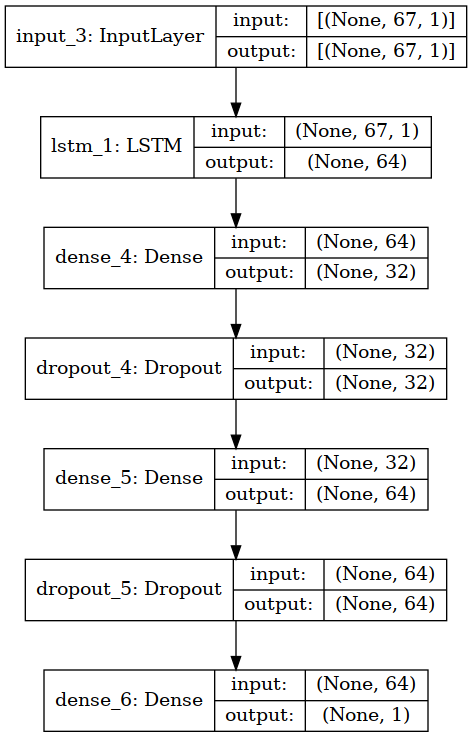

In [14]:
from tensorflow.keras.utils import plot_model
from keras.models import load_model

cnn_loaded = load_model('../../models/cnn_insdn_model.keras')
lstm_loaded = load_model('../../models/lstm_insdn_model.keras')
ae_lstm_loaded = load_model('../../models/ae-lstm_insdn_model.keras')

plot_model(cnn_loaded, to_file='../../results/InSDN/CNN_model.png', show_shapes=True, show_layer_names=True)
plot_model(lstm_loaded, to_file='../../results/InSDN/LSTM_model.png', show_shapes=True, show_layer_names=True)
plot_model(ae_lstm_loaded, to_file='../../results/InSDN/AE-LSTM_model.png', show_shapes=True, show_layer_names=True)

### CNN metrics

              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99     20528
     Attacks       0.99      1.00      0.99     20527

    accuracy                           0.99     41055
   macro avg       0.99      0.99      0.99     41055
weighted avg       0.99      0.99      0.99     41055

Test Loss: 0.0184
Test Accuracy: 0.9930


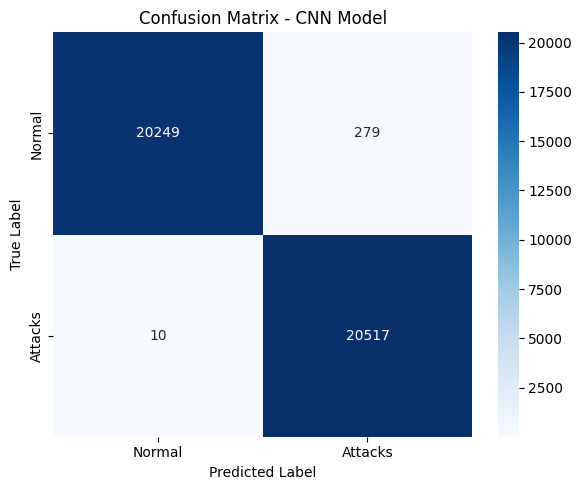

Attacks detected (True Positive) : 20517
Normal traffic detected (True Negative) : 20249
Attacks missed (False Negative) : 10
False alarms (False Positive) : 279


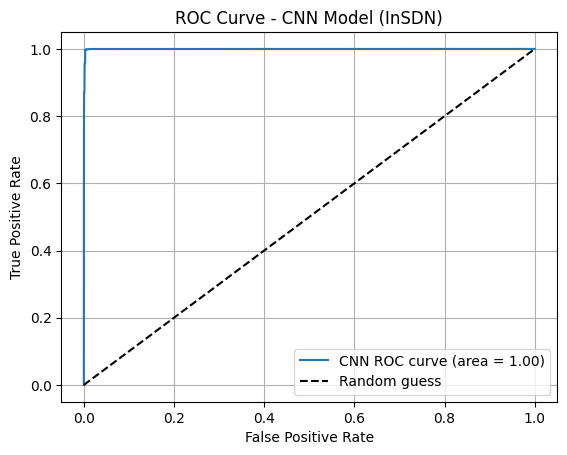

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_prob = CNN_model.predict(X_test)


y_pred = (y_pred_prob > 0.5).astype("int32")

# (precision, recall, F1-score)
print(classification_report(Y_test, y_pred, labels=[0,1], target_names=["Normal", "Attacks"]))

# Accuracy and loss
loss, accuracy = CNN_model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# confusion Matrix
cm = confusion_matrix(Y_test, y_pred, labels=[0,1],)
labels = ["Normal", "Attacks"]
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - CNN Model')
plt.tight_layout()
plt.savefig("../../results/InSDN/CNN_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

# displaying the attack number
tn, fp, fn, tp = cm.ravel()
print(f"Attacks detected (True Positive) : {tp}")
print(f"Normal traffic detected (True Negative) : {tn}")
print(f"Attacks missed (False Negative) : {fn}")
print(f"False alarms (False Positive) : {fp}")

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'CNN ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CNN Model (InSDN)')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig("../../results/InSDN/CNN_ROC_curve.png", dpi=300, bbox_inches='tight')
plt.show()


### LSTM metrics

              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99     20528
     Attacks       0.99      1.00      0.99     20527

    accuracy                           0.99     41055
   macro avg       0.99      0.99      0.99     41055
weighted avg       0.99      0.99      0.99     41055

Test Loss: 0.0257
Test Accuracy: 0.9930


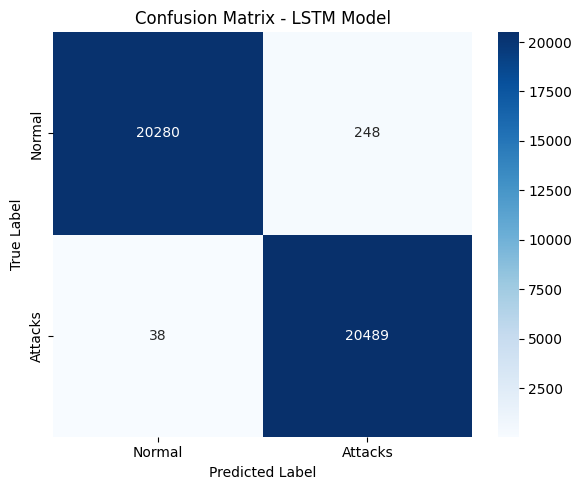

Attacks detected (True Positive) : 20489
Normal traffic detected (True Negative) : 20280
Attacks missed (False Negative) : 38
False alarms (False Positive) : 248


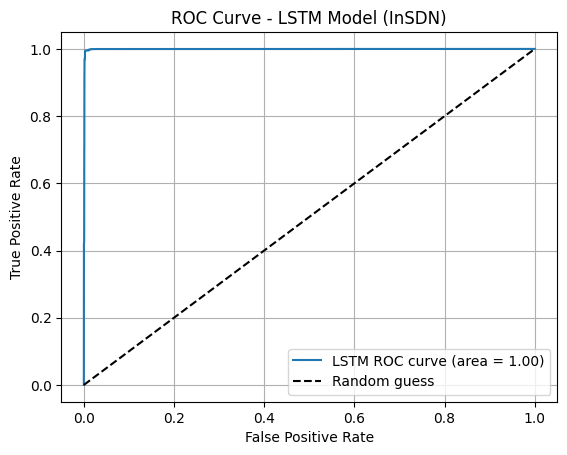

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_prob = LSTM_model.predict(X_test)


y_pred = (y_pred_prob > 0.5).astype("int32")

# (precision, recall, F1-score)
print(classification_report(Y_test, y_pred, labels=[0,1], target_names=["Normal", "Attacks"]))

# Accuracy and loss
loss, accuracy = LSTM_model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# confusion Matrix
cm = confusion_matrix(Y_test, y_pred, labels=[0,1],)
labels = ["Normal", "Attacks"]
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - LSTM Model')
plt.tight_layout()
plt.savefig("../../results/InSDN/LSTM_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

# displaying the attack number
tn, fp, fn, tp = cm.ravel()
print(f"Attacks detected (True Positive) : {tp}")
print(f"Normal traffic detected (True Negative) : {tn}")
print(f"Attacks missed (False Negative) : {fn}")
print(f"False alarms (False Positive) : {fp}")

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'LSTM ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LSTM Model (InSDN)')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig("../../results/InSDN/LSTM_ROC_curve.png", dpi=300, bbox_inches='tight')
plt.show()


### AE-LSTM metrics

              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99     20528
     Attacks       0.99      1.00      0.99     20527

    accuracy                           0.99     41055
   macro avg       0.99      0.99      0.99     41055
weighted avg       0.99      0.99      0.99     41055

Test Loss: 0.0261
Test Accuracy: 0.9926


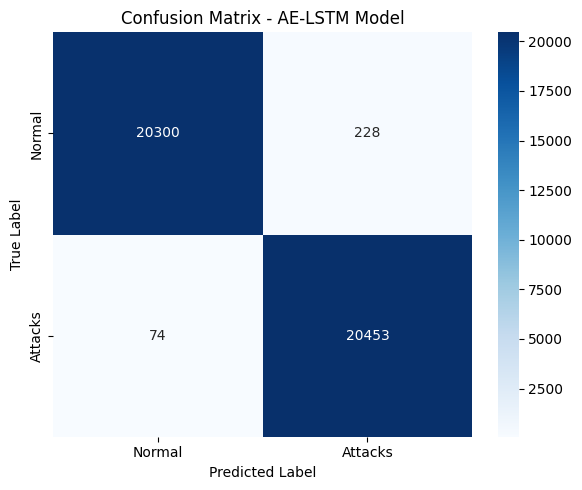

Attacks detected (True Positive) : 20453
Normal traffic detected (True Negative) : 20300
Attacks missed (False Negative) : 74
False alarms (False Positive) : 228


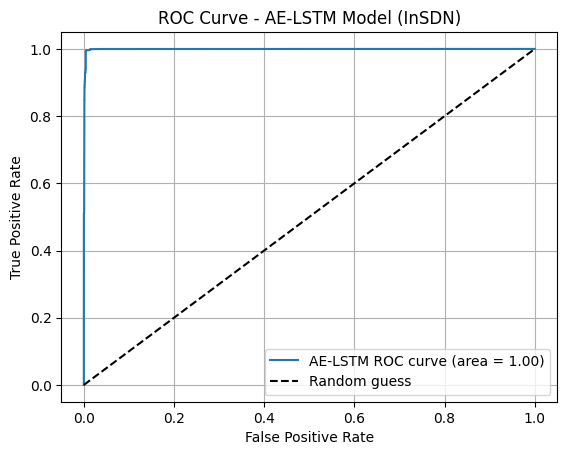

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_prob = AE_LSTM_model.predict(X_test)


y_pred = (y_pred_prob > 0.5).astype("int32")

# (precision, recall, F1-score)
print(classification_report(Y_test, y_pred, labels=[0,1], target_names=["Normal", "Attacks"]))

# Accuracy and loss
loss, accuracy = AE_LSTM_model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# confusion Matrix
cm = confusion_matrix(Y_test, y_pred, labels=[0,1],)
labels = ["Normal", "Attacks"]
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - AE-LSTM Model')
plt.tight_layout()
plt.savefig("../../results/InSDN/AE-LSTM_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

# displaying the attack number
tn, fp, fn, tp = cm.ravel()
print(f"Attacks detected (True Positive) : {tp}")
print(f"Normal traffic detected (True Negative) : {tn}")
print(f"Attacks missed (False Negative) : {fn}")
print(f"False alarms (False Positive) : {fp}")

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'AE-LSTM ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - AE-LSTM Model (InSDN)')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig("../../results/InSDN/AE-LSTM_ROC_curve.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
import pickle

In [ ]:
file_name_cnn = '../../models/cnn_InSDN.pkl' 
joblib.dump(CNN_model, file_name_cnn) 

file_name_lstm = '../../models/lstm_InSDN.pkl' 
joblib.dump(LSTM_model, file_name_lstm) 

file_name_ae_lstm = '../../models/ae-lstm_InSDN.pkl' 
joblib.dump(AE_LSTM_model, file_name_ae_lstm)

TypeError: cannot pickle 'weakref' object

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_prob = CNN_model.predict(X_test)


y_pred = (y_pred_prob > 0.5).astype("int32")

# (precision, recall, F1-score)
print(classification_report(Y_test, y_pred, target_names=["Normal", "Attacks"]))

# Confusion Matrix
cm = confusion_matrix(Y_test, y_pred)
print("Confusion matrix :\n", cm)

# Displaying the attack number
tn, fp, fn, tp = cm.ravel()
print(f"Attacks detected (True Positive) : {tp}")
print(f"Normal traffic detected (True Negative) : {tn}")
print(f"Attacks missed (False Negative) : {fn}")
print(f"False alarms (False Positive) : {fp}")

1283/1283 [==============================] - 1s 571us/step
              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99     20528
     Attacks       0.99      1.00      0.99     20527

    accuracy                           0.99     41055
   macro avg       0.99      0.99      0.99     41055
weighted avg       0.99      0.99      0.99     41055

Confusion matrix :
 [[20248   280]
 [   10 20517]]
Attacks detected (True Positive) : 20517
Normal traffic detected (True Negative) : 20248
Attacks missed (False Negative) : 10
False alarms (False Positive) : 280
